In [3]:
import pytesseract
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from pprint import pprint
from pytesseract import Output
from imutils.object_detection import non_max_suppression

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'
os.environ['TESSDATA_PREFIX'] = '/usr/local/Cellar/tesseract-lang/4.1.0/share/tessdata'


## Pre processing the image

(1024, 576, 3)
1.8 3.2
(320, 320, 3)


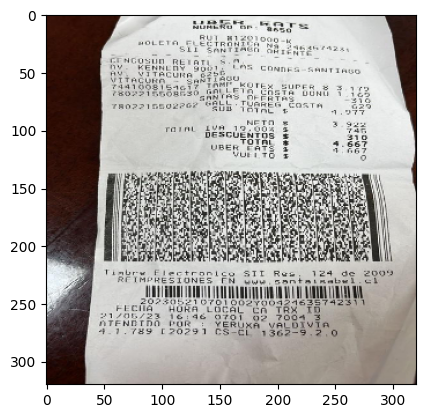

In [12]:
width, height = 320, 320
min_confidence = 0.9

img = cv2.imread('../images/1c5e5931-8337-40bb-9ff6-3718b941c902.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original = img.copy()

print(img.shape)
H = img.shape[0]
W = img.shape[1]

# get proportions
proportion_width =  W / float(width)
proportion_height = H / float(height)
print(proportion_width, proportion_height)

# resize image
resized = cv2.resize(img, (width, height))
print(resized.shape)

H = resized.shape[0]
W = resized.shape[1]



plt.imshow(resized, cmap='gray')
plt.show()

## Loading the neural network

In [19]:

blob = cv2.dnn.blobFromImage(resized, 1.0, (W, H), swapRB=True, crop=False)
print(blob.shape)

# Define the names of the layers we want to extract output from
layers_names = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

# Load the pre-trained neural network model
neural_network = cv2.dnn.readNet("./frozen_east_text_detection.pb")

# Set the blob as the input to the neural network and get the output scores and geometry
neural_network.setInput(blob)
scores, geometry = neural_network.forward(layers_names)

print(scores.shape[2:4])

rows, columns = scores.shape[2:4]

boxes = []
confidences = []


(1, 3, 320, 320)
(80, 80)


## Decoding the values

In [27]:
def geometry_data(geometry, y):
  XData0 = geometry[0,0,y]
  XData1 = geometry[0,1,y]
  XData2 = geometry[0,2,y]
  XData3 = geometry[0,3,y]
  angles_data = geometry[0,4,y]
  return angles_data, XData0, XData1, XData2, XData3


def geometric_calculation(angles_data, XData0, XData1, XData2, XData3):
  (offsetX, offsetY) = (x * 4.0, y * 4.0)
  angle = angles_data[x]
  cos = np.cos(angle)
  sin = np.sin(angle)
  h = XData0[x] + XData2[x]
  w = XData1[x] + XData3[x]

  endX = int(offsetX + (cos * XData1[x]) + (sin * XData2[x]))
  endY = int(offsetY - (sin * XData1[x]) + (cos * XData2[x]))
  
  beginX = int(endX - w)
  beginY = int(endY - h)
  
  return beginX, beginY, endX, endY
  

for y in range(0, rows):
  data_scores = scores[0,0,y]
  angles_data, XData0, XData1, XData2, XData3 = geometry_data(geometry, y)
  
  for x in range(0, columns):
    if data_scores[x] < min_confidence:
      continue
    beginX, beginY, endX, endY = geometric_calculation(angles_data, XData0, XData1, XData2, XData3)
    confidences.append(data_scores[x])
    boxes.append((beginX, beginY, endX, endY))
  
detections = non_max_suppression(np.array(boxes), probs=confidences)
print(detections)

[[241  42 278  54]
 [187  42 221  54]
 [111 261 135 279]
 [ 67  34 108  46]
 [ 59 220  84 236]
 [218  59 247  74]
 [ 79 257  96 281]
 [137  94 170 109]
 [ 61 258  83 280]
 [274 216 304 233]
 [ 73  16 114  30]
 [205  22 249  36]
 [161  38 183  55]
 [127  38 152  56]
 [142 110 174 123]
 [ 66  47 108  63]
 [ 58  72 110  86]
 [157 134 242 158]
 [200  59 223  72]
 [289 164 309 213]
 [166  22 188  36]
 [127   2 162  16]]


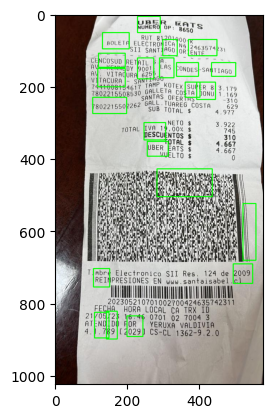

In [43]:
img_copy = original.copy()

for (beginX, beginY, endX, endY) in detections:
  
  beginX = int(beginX * proportion_width)
  beginY = int(beginY * proportion_height)
  endX = int(endX * proportion_width)
  endY = int(endY * proportion_height)
  
  roi = img_copy[beginY:endY, beginX:endX]
  
  cv2.rectangle(img_copy, (beginX, beginY), (endX, endY), (0, 255, 0), 2)
    
plt.imshow(img_copy, cmap='gray')
plt.show()

NTIAGO

CONDES:


NCOSUD

YA

imbre
REI

PER 8
DONU


IVA 15
DESCUE


2009

BOLETA

(3

Kk
2463574;
NTE




RINA
y VITAC
[TACURA

AÁRADOS E


780221550:








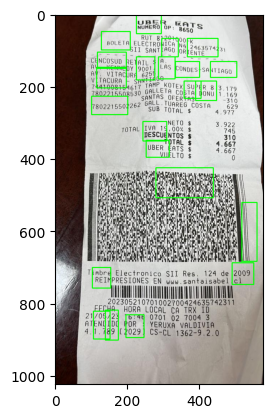

In [45]:

# adding a margin in each box to not miss dots, commas, etc.
margin = 3
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
  beginX = int(beginX * proportion_width)
  beginY = int(beginY * proportion_height)
  endX = int(endX * proportion_width)
  endY = int(endY * proportion_height)

  roi = img_copy[beginY - margin:endY + margin, beginX - margin:endX + margin]
  text = pytesseract.image_to_string(roi, lang = 'spa')
  print(text)

  cv2.rectangle(img_copy, (beginX - margin, beginY - margin), (endX + margin, endY + margin), (0,255,0), 2)
  
plt.imshow(img_copy, cmap='gray')
plt.show()